# 4. Train/Test Splitting, Overfitting/Underfitting and Generalization

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (25/11/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Sklearn (tested on v0.0.post1)

### Imports

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

### Mock dataset generation

As in Notebook 3., we will generate prices $ y_i $ as a polynomial function  of the surface $ x_i $.

In this notebook, we will assume that the function f(x), giving the price of an appartment with surface $ x $, will be defined as

$$ f(x) = 100000 + 14373x + 3x^3. $$

In addition, we will add a random noise to the final pricing, with a $ +/- 5\% $ drift as before.

In [2]:
# All helper functions
min_surf = 40
max_surf = 150
def surface(min_surf, max_surf):
    # Note, we changed the surface inputs to be normalized by the value of max_surf.
    return round(np.random.uniform(min_surf, max_surf), 2)
def price(surface):
    # Note: this will return the price in millions of SGD.
    surface = surface
    return round((100000 + 14373*surface + 3*surface**3)*(1 + np.random.uniform(-0.1, 0.1)))/1000000
def get_x_list(l):
    return [v[0] for v in l]
def get_y_list(l):
    return [v[1] for v in l]
def linreg(a, b, min_surf, max_surf, n_points = 50):
    return [(x, a*x + b) for x in np.linspace(min_surf, max_surf, n_points)]
def loss_mse(a, b, x, y):
    val =  sum([(y_i - (a*x_i + b))**2 for x_i, y_i in zip(x, y)])/len(x)
    return '{:.2e}'.format(val)

In [3]:
# Dataset generation (n_points points will be generated).
# We will use a seed for reproducibility.
np.random.seed(27)
n_points = 25
dataset = [(s := surface(min_surf, max_surf), price(s)) for _ in range(n_points)]
inputs = get_x_list(dataset)
outputs = get_y_list(dataset)
print(inputs)
print(outputs)

[86.83, 120.89, 82.17, 138.25, 121.6, 137.55, 122.42, 60.54, 81.02, 56.62, 48.93, 126.16, 47.77, 59.91, 85.68, 64.27, 133.44, 120.95, 94.22, 48.36, 146.31, 50.17, 132.06, 117.5, 117.63]
[3.520336, 7.663097, 3.227885, 9.432815, 7.478187, 10.592089, 7.908657, 1.578728, 3.028009, 1.362073, 1.109714, 7.402192, 1.158411, 1.63795, 3.227162, 1.902297, 9.930666, 7.113048, 4.038439, 1.04759, 11.792209, 1.083209, 9.646353, 6.505124, 7.23857]


### Train-Test Splitting

This time, we will perform a train-test split. Remember, the goal of supervised learning is to build a model that performs well ((or in other words, generalizes well) on new unseen data. If you have new data, it is a good idea to use this data to see how your model performs on it. In practice, however, the problem often is that you may not have new data, but you can simulate this experience with a procedure like a train-test split.

The core idea is the following:
- We will use a large part (say 80%) of the dataset to train our model and decide its parameters,
- We will then use the remaining data (20%), to evaluate the performance of the model and decide if it generalizes well.

We can simply perform a train-test split, using slicing, as shown below. You may also use the train-test split functions from sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [4]:
ratio_train = 0.8
split_index = int(n_points*ratio_train)
# Training inputs and outputs
train_dataset = dataset[:split_index]
train_inputs = get_x_list(train_dataset)
train_outputs = get_y_list(train_dataset)
# Testing inputs and outputs
test_dataset = dataset[split_index:]
test_inputs = get_x_list(test_dataset)
test_outputs = get_y_list(test_dataset)
# Display
print(train_inputs)
print(train_outputs)
print(test_inputs)
print(test_outputs)

[86.83, 120.89, 82.17, 138.25, 121.6, 137.55, 122.42, 60.54, 81.02, 56.62, 48.93, 126.16, 47.77, 59.91, 85.68, 64.27, 133.44, 120.95, 94.22, 48.36]
[3.520336, 7.663097, 3.227885, 9.432815, 7.478187, 10.592089, 7.908657, 1.578728, 3.028009, 1.362073, 1.109714, 7.402192, 1.158411, 1.63795, 3.227162, 1.902297, 9.930666, 7.113048, 4.038439, 1.04759]
[146.31, 50.17, 132.06, 117.5, 117.63]
[11.792209, 1.083209, 9.646353, 6.505124, 7.23857]


As before, we provide a display, showing the data, with two different colors for train and test datasets.

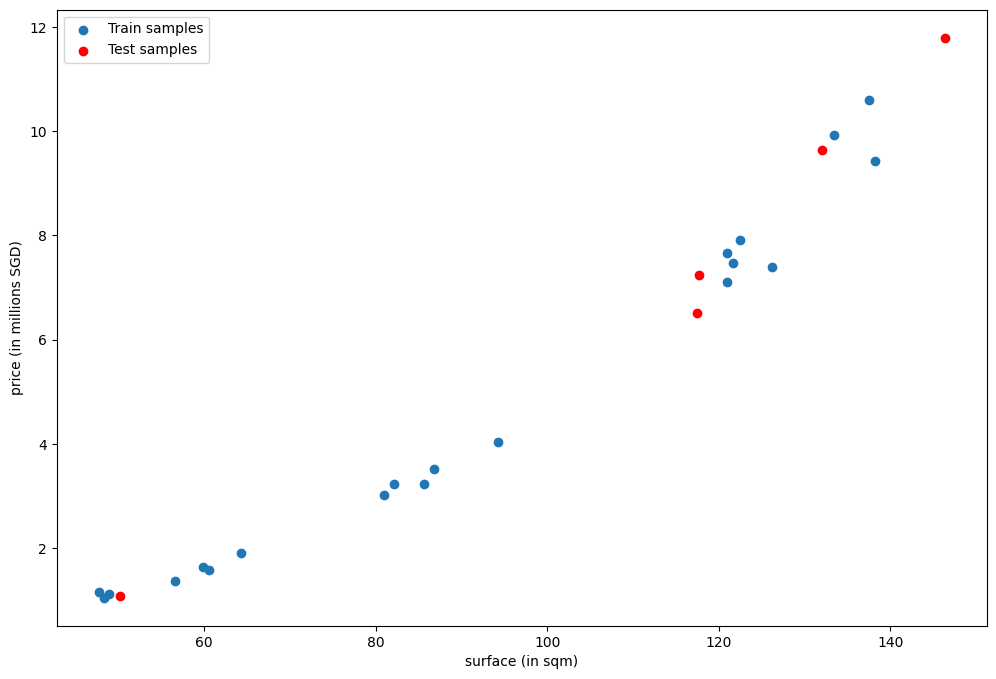

In [5]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'r', label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Display
plt.legend(loc = 'best')
plt.show()

In [6]:
# Training a Polynomial Regressor
n_degree = 6
sk_inputs = np.array(train_inputs).reshape(-1, 1)
sk_outputs = np.array(train_outputs)
sk_poly = PolynomialFeatures(degree = n_degree, include_bias = False)
sk_poly_inputs = sk_poly.fit_transform(sk_inputs.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(sk_poly_inputs, sk_outputs)
a_sk = poly_reg_model.coef_
b_sk = poly_reg_model.intercept_
print(a_sk, b_sk)

[ 5.18462401e+00 -1.72902850e-01  2.98769414e-03 -2.80005264e-05
  1.35374281e-07 -2.63855771e-10] -62.44823280258608


In [7]:
def polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points = 50):
    return [(x, poly_reg_model.predict(np.array([[x**(i+1) for i in range(n_degree)]]))) for x in np.linspace(min_surf, max_surf, n_points)]

In [8]:
def loss_mse_poly(poly_reg_model, n_degree, inputs, outputs):
    values = [(y, poly_reg_model.predict(np.array([[x**(i+1) for i in range(n_degree)]]))[0]) for x, y in zip(inputs, outputs)]
    losses = [(v[0] - v[1])**2 for v in values]
    val = sum(losses)/len(inputs)
    return '{:.2e}'.format(val)

In [9]:
loss_train = loss_mse_poly(poly_reg_model, n_degree, train_inputs, train_outputs)
print(loss_train)
loss_test = loss_mse_poly(poly_reg_model, n_degree, test_inputs, test_outputs)
print(loss_test)

9.95e-02
1.39e+00


In [10]:
# Training a Polynomial Regressor
n_degree2 = 3
sk_inputs2 = np.array(train_inputs).reshape(-1, 1)
sk_outputs2 = np.array(train_outputs)
sk_poly2 = PolynomialFeatures(degree = n_degree2, include_bias = False)
sk_poly_inputs2 = sk_poly2.fit_transform(sk_inputs2.reshape(-1, 1))
poly_reg_model2 = LinearRegression()
poly_reg_model2.fit(sk_poly_inputs2, sk_outputs2)
a_sk2 = poly_reg_model2.coef_
b_sk2 = poly_reg_model2.intercept_
print(a_sk2, b_sk2)

[8.17550758e-03 1.65700243e-04 2.20404220e-06] 0.05787661684289258


In [11]:
loss_train2 = loss_mse_poly(poly_reg_model2, n_degree2, train_inputs, train_outputs)
print(loss_train2)
loss_test2 = loss_mse_poly(poly_reg_model2, n_degree2, test_inputs, test_outputs)
print(loss_test2)

1.06e-01
1.13e-01


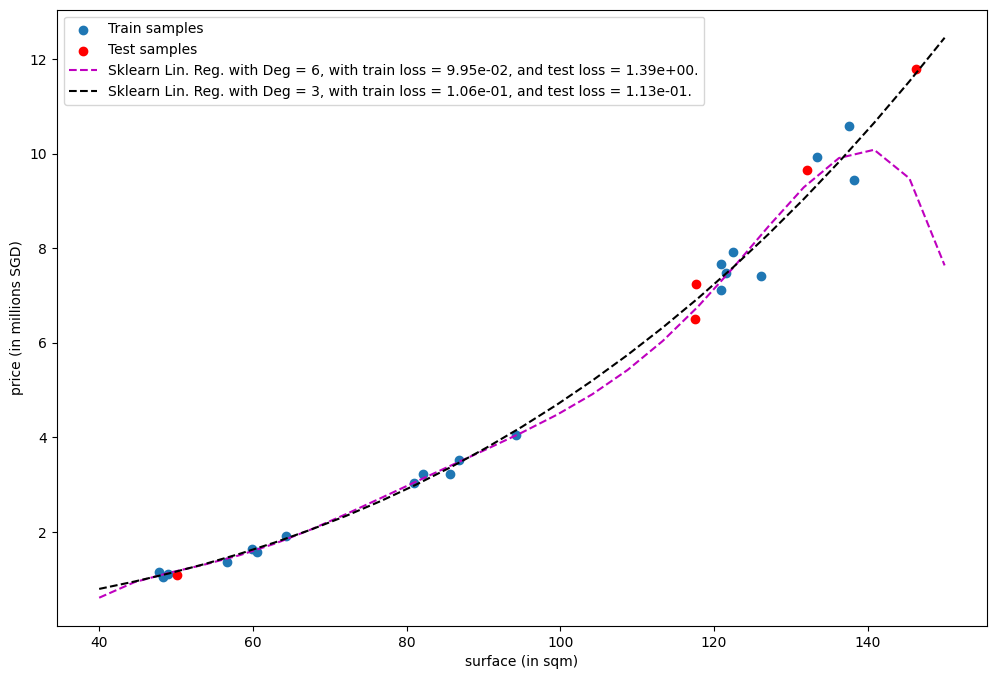

In [12]:
# Display dataset
plt.figure(figsize = (12, 8))
plt.scatter(train_inputs, train_outputs, label = 'Train samples')
plt.scatter(test_inputs, test_outputs, c = 'r', label = 'Test samples')
plt.xlabel("surface (in sqm)")
plt.ylabel("price (in millions SGD)")

# Optimal linreg
polyreg_dataset = polyreg(poly_reg_model, n_degree, min_surf, max_surf, n_points)
legend = "Sklearn Lin. Reg. with Deg = 6, with train loss = {}, and test loss = {}.".format(loss_train, loss_test)
plt.plot(get_x_list(polyreg_dataset), get_y_list(polyreg_dataset), 'm--', label = legend)

# Optimal linreg
polyreg_dataset2 = polyreg(poly_reg_model2, n_degree2, min_surf, max_surf, n_points)
legend2 = "Sklearn Lin. Reg. with Deg = 3, with train loss = {}, and test loss = {}.".format(loss_train2, loss_test2)
plt.plot(get_x_list(polyreg_dataset2), get_y_list(polyreg_dataset2), 'k--', label = legend2)

# Display
plt.legend(loc = 'best')
plt.show()

In [13]:
def theoretical_values(surface, max_surf):
    avg_val = round((100000 + 14373*surface + 3*surface**3))/1000000
    min_val = 0.9*avg_val
    max_val = 1.1*avg_val
    return [min_val, avg_val, max_val]

In [14]:
new_appt_surface1 = 50
pred_price1 = poly_reg_model.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price1, theoretical_values(new_appt_surface1, max_surf))
new_appt_surface2 = 98
pred_price2 = poly_reg_model.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price2, theoretical_values(new_appt_surface2, max_surf))
new_appt_surface3 = 150
pred_price3 = poly_reg_model.predict(np.array([[(new_appt_surface3)**(i+1) for i in range(n_degree)]]))[0]
print(pred_price3, theoretical_values(new_appt_surface3, max_surf))

1.166035332591946 [1.0742850000000002, 1.19365, 1.3130150000000003]
4.342016706263095 [3.8989170000000004, 4.33213, 4.7653430000000006]
7.6347586680526405 [11.142855, 12.38095, 13.619045000000002]


In [15]:
new_appt_surface1 = 50
pred_price1b = poly_reg_model2.predict(np.array([[(new_appt_surface1)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price1b, theoretical_values(new_appt_surface1, max_surf))
new_appt_surface2 = 98
pred_price2b = poly_reg_model2.predict(np.array([[(new_appt_surface2)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price2b, theoretical_values(new_appt_surface2, max_surf))
new_appt_surface3 = 150
pred_price3b = poly_reg_model2.predict(np.array([[(new_appt_surface3)**(i+1) for i in range(n_degree2)]]))[0]
print(pred_price3b, theoretical_values(new_appt_surface3, max_surf))

1.1564078786657328 [1.0742850000000002, 1.19365, 1.3130150000000003]
4.524888381699619 [3.8989170000000004, 4.33213, 4.7653430000000006]
12.451100652852134 [11.142855, 12.38095, 13.619045000000002]
